# RNN Project - YouTube Comment Sentiment Analysis
### by HELLER Theo

## Introduction

### Project Objective
In this project, we use a Recurrent Neural Network (RNN) to analyze and classify the toxicity of YouTube comments. RNNs are well-suited for handling sequential data like text due to their ability to capture temporal or contextual dependencies.

### Context
The dataset used in this project comes from the Kaggle competition **"Jigsaw Unintended Bias in Toxicity Classification."** It contains comments annotated based on their level of toxicity. The goal is to develop a model capable of predicting whether a comment is toxic or not.

### Methodology
The project is divided into several steps:
1. Importing the dataset.
2. Data preprocessing: cleaning the textual comments.
3. Building and training RNN model using TensorFlow/Keras.
4. Evaluating the model on the dataset.
5. Analyzing the results and visualizing performance.

### Expected Results
This project is designed as a small-scale exercise, aiming to produce a reasonably accurate model given the limited computational resources available. The focus is on assembling building blocks to understand how to analyze text data and create a viable model for toxicity classification.

**Dataset:**
- Source: [Kaggle - Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)
- Size: ~2 million annotated comments.


# 1. Importing the Dataset

We use the dataset *Jigsaw Unintended Bias in Toxicity Classification*, which contains millions of textual comments. Each comment is annotated with a toxicity score ranging from 0 (non-toxic) to 1 (very toxic). Our goal is to binarize this score to predict whether a comment is toxic (1) or non-toxic (0).

### Key Steps:
- Load the data.
- Analyze its structure and remove unnecessary columns.

The file is available in CSV format and can be downloaded from Kaggle.


In [21]:
import pandas as pd

# Loading data
dataset_path = "../data/all_data.csv"  # Replace with the exact path
data = pd.read_csv(dataset_path)

# Display of first lines
data.head(2)

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76


In [22]:
# Overview of columns and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 46 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   comment_text                         object 
 2   split                                object 
 3   created_date                         object 
 4   publication_id                       int64  
 5   parent_id                            float64
 6   article_id                           int64  
 7   rating                               object 
 8   funny                                int64  
 9   wow                                  int64  
 10  sad                                  int64  
 11  likes                                int64  
 12  disagree                             int64  
 13  toxicity                             float64
 14  severe_toxicity                      float64
 15  obscene                         

We want to analyse the text comments and the associated toxicity scores. We will therefore only load the `comment_text`, `target`, `toxicity` and `toxicity_annotator_count` columns.

In [23]:
# Removing unnecessary columns
columns_to_keep=['comment_text',
                 'split',  
                 'toxicity',
                 'toxicity_annotator_count'
                 ]

data=data[columns_to_keep]
data.columns

data.head(2)

,comment_text,split,toxicity,toxicity_annotator_count
0,He got his money... now he lies in wait till a...,train,0.373134,67
1,Mad dog will surely put the liberals in mental...,train,0.605263,76


As we have limited computing power, we will only keep comments that have been annotated by at least 5 annotators in order to reduce the size of the dataset and speed up model training by keeping only the most significant comments.

In [24]:
print(data[data['toxicity_annotator_count']>=5].count())
data = data[data['toxicity_annotator_count']>=5]

comment_text                685630
split                       685630
toxicity                    685630
toxicity_annotator_count    685630
dtype: int64


We will check the rows with missing values and delete them if necessary.

In [25]:
# Checking for missing values
missing_values = data.isnull().sum()
print("\nValeurs manquantes par colonne :")
print(missing_values[missing_values > 0])


Valeurs manquantes par colonne :
Series([], dtype: int64)


We're going to look at the distribution of classes to check whether the dataset is balanced or not.

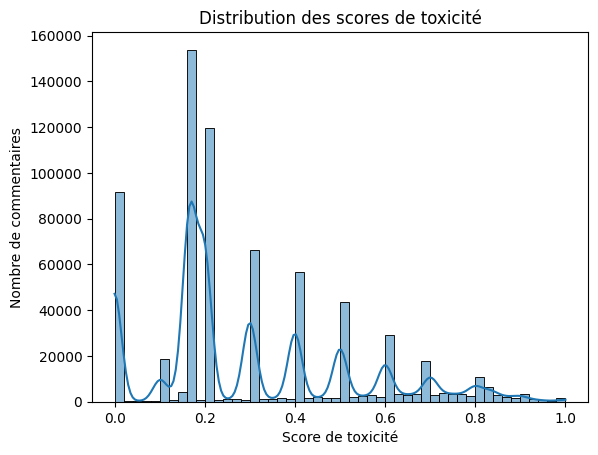

In [26]:
# Toxicty score distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['toxicity'], bins=50, kde=True)
plt.title("Distribution des scores de toxicité")
plt.xlabel("Score de toxicité")
plt.ylabel("Nombre de commentaires")
plt.show()

We can see that the dataset is unbalanced, with a majority of non-toxic comments. We will see how to manage this imbalance during the model training phase. For the moment, we're simply going to binarise the toxicity scores, considering a comment to be toxic if the score is greater than 0.5. This will provide a first simplified version of the problem which will help us to have a first functional model.

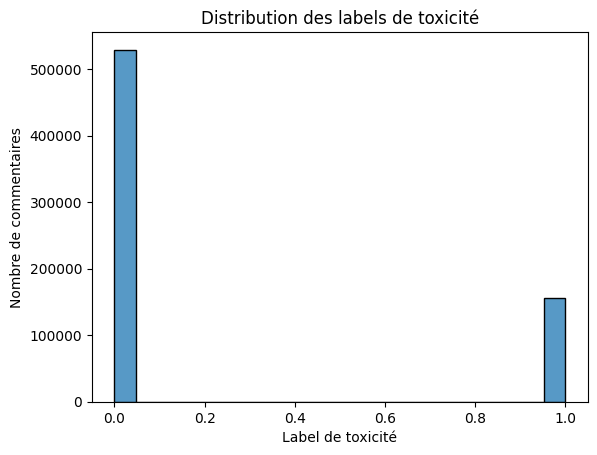

In [27]:
# Creation of a toxicity_label column with values of 0 or 1 and a pivot of 0.5
data['toxicity_label'] = (data['toxicity'] >= 0.5).astype(int)
data['toxicity_label'].value_counts(normalize=True)


# Toxicity label distribution
sns.histplot(data['toxicity_label'])
plt.title("Distribution des labels de toxicité")
plt.xlabel("Label de toxicité")
plt.ylabel("Nombre de commentaires")
plt.show()


# 2. Preprocessing Text Data

To train a natural language processing model, raw text data needs to be cleaned and prepared. 

### Key Steps:
- **Cleaning**: removing special characters, HTML tags, and extra spaces.
- **Tokenization**: splitting sentences into words.
- **Lemmatization**: reducing words to their canonical form.
- **Conversion**: convertion of words into numerical sequences compatible with deep learning models.

**Disclaimer**: These steps are followed to simplify the model due to the limited computational resources available. In practice, however, we often retain more complex preprocessing steps and techniques to better capture the nuances of the text, such as stemming, removing stop words, or using more advanced tokenization methods. The simplifications made here are only for the purpose of this specific project.


We are not going to remove stopwords for the time being, as they may contain useful information for classifying the toxicity of comments. We can always remove them later if necessary.

In [28]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# global initialization of the WordNetLemmatizer
wordlem = WordNetLemmatizer()

# Function to process a comment
def process_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Delete HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    
    # Keep only letters and spaces
    comment = re.sub(r'[^a-z\s]', '', comment)

    # Delete multiple spaces
    comment = re.sub(r'\s+', ' ', comment).strip()

    # Tokenization
    tokens = word_tokenize(comment)

    # Lemmatization
    final_tokens = [wordlem.lemmatize(w) for w in tokens]

    return ' '.join(final_tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [29]:
# Application of the function to the comment_text column
data['comment_text_cleaned'] = data['comment_text'].apply(process_comment)

In [32]:
# Display of the result before and after cleaning
print("Example before cleaning:")
print(data['comment_text'].iloc[0])
print("\nExemple after cleaning :")
print(data['comment_text_cleaned'].iloc[0])

Example before cleaning:
He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.

Exemple after cleaning :
he got his money now he lie in wait till after the election in yr dirty politician need to be afraid of tar and feather again but they arent and so the people get screwed


Again, to reduce the size of the dataset, we will limit the length of comments to 100 words, as longer comments are more complex to process with our limited computing power and represent only a small proportion of comments.

In [33]:
data['word_count'] = data['comment_text_cleaned'].apply(lambda x: len(str(x).split(" ")))

maxlen = 100
minlen = 1

print("Proportion of comments with strictly more than {} words:".format(maxlen))
print(data[data['word_count'] > maxlen].shape[0]/data.shape[0]*100)

print("Proportion of comments with strictly less than {} words:".format(minlen))
print(data[data['word_count'] < minlen].shape[0]/data.shape[0]*100)


Proportion of comments with strictly more than 100 words:
16.489797704301154
Proportion of comments with strictly less than 1 words:
0.0


In [34]:
# Data filtering according to the number of words in the comment
data = data[(data['word_count'] <= maxlen) & (data['word_count'] >= minlen)]
data = data.drop(['word_count'], axis=1)

print("Number of comments after cleaning and filtering:", data.shape[0])

Number of comments after cleaning and filtering: 572571


We are now going to tokenise the comments and transform them into digital sequences that can be interpreted by a deep learning model.

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the parameters of the tokenizer
vocab_size = 25000  # Maximum number of words to keep
max_length = 100    # Maximum length of sequences (padding)

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data['comment_text_cleaned'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(data['comment_text_cleaned'])

# Apply padding to sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
data['padded_sequences'] = list(padded_sequences)

print(f"Padded sequences shape: {padded_sequences.shape}")

Padded sequences shape: (572571, 100)


In [36]:
# Count the "<OOV>" words in the sequences
oov_index = tokenizer.word_index.get("<OOV>")  # Retrieve the index assigned to the "<OOV>" token
oov_count = sum(sequence.count(oov_index) for sequence in sequences)

print(f"Total number of <OOV> words generated: {oov_count}")

total_words = sum(len(sequence) for sequence in sequences)
oov_proportion = oov_count / total_words

print(f"Proportion of <OOV> words: {oov_proportion:.2%}")


Total number of <OOV> words generated: 381723
Proportion of <OOV> words: 1.83%


We notice that with 25,000 unique words, we are able to cover more than 98% of the words in the dataset. We will therefore limit our vocabulary to 25,000 words to reduce the complexity of the model.

In [37]:
print("Example of sequence after tokenization and padding:")
print(padded_sequences[0])

Example of sequence after tokenization and padding:
[  22  178   38  120   73   22  214    8  490 2636  146    2  230    8
 3050 1107  356   78    3   16 1127    6 4964    5 4632  163   28   20
  387    5   35    2   36   53 1666    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Now that the text data is preprocessed, we can save it into a new CSV file to use it in the next steps of the project.

In [38]:
# Removing unnecessary columns

columns_to_keep=['split',  
                 'toxicity',
                 'toxicity_label',
                 'padded_sequences'
                 ]

data=data[columns_to_keep]
data.columns

data.head(2)

,split,toxicity,toxicity_label,padded_sequences
0,train,0.373134,0,"[22, 178, 38, 120, 73, 22, 214, 8, 490, 2636, ..."
1,train,0.605263,1,"[1689, 434, 32, 1458, 196, 2, 110, 8, 751, 181..."


In [39]:
data.shape

(572571, 4)

In [40]:
# Saving the tokenizer and cleaned data
import pickle

with open('../data/cleaned_dataset.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../src/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("The cleaned data and tokenizer have been saved.")


The cleaned data and tokenizer have been saved.
